In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import re
import ast
# from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [210]:
# Load the artists data as a list type
generic = lambda x: ast.literal_eval(x)
conv = {'artists': generic}
df = pd.read_csv("data.csv", converters=conv)

In [211]:
df.shape

(174389, 19)

In [212]:
features = df.columns.drop(["id", "artists", "name"])

In [213]:
X_data, target = df[features], df["artists"]

In [214]:
X_data.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920


In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2, random_state=1)

## Missing values

In [216]:
df.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

## Variable types

In [217]:
df.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

## Output space exploratory analysis (distribution of the register over the classes)

In [218]:
artists_by_register_count = df["artists"].apply(lambda x: len(x))

In [219]:
print("Maximum number of artists on a single register: {}".format(artists_by_register_count.max()))

Maximum number of artists on a single register: 28


In [220]:
df["artists"].iloc[np.argmax(artists_by_register_count)]

['Peter Moon Band',
 'Nathan Aweau',
 'Peter Moon',
 'Pauline Wilson',
 'Danny Kaleikini',
 'Dennis Pavao',
 'Kahala Moon',
 'Allan Thomas',
 'Teresa Bright',
 'Gabby Pahinui',
 'Darlene Ahuna',
 'Ken Emerson',
 'Joe Recca',
 'The Sunday Manoa',
 'Robert Cazimero',
 'Roland Cazimero',
 'Lorna Lim',
 'Kohala',
 'Jay Larrin',
 'Country Comfort',
 'George Helm',
 'Melveen Leed',
 'Buddy Fo',
 'The Invitations',
 'Robi Kahakalau',
 'Charles Michael Brotman',
 'Moe Keale',
 '2004 Hawaii Music Awards Compilation Of The Year']

In [221]:
# Get all posible values
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [222]:
artist_count = to_1D(target).value_counts()

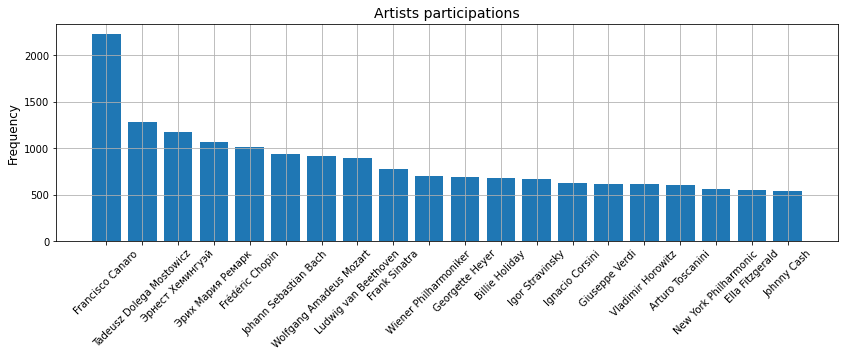

In [223]:
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(artist_count.iloc[0:20].index,
        artist_count.iloc[0:20].values)

ax.set_ylabel("Frequency", size = 12)
ax.set_title("Artists participations", size = 14)
ax.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Some of the artists are novelists, so we can infer that in their case are audiobooks fragments

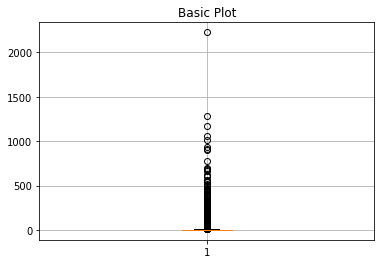

In [224]:
fig, ax = plt.subplots()
ax.set_title('Basic Plot')
ax.boxplot(artist_count)
ax.grid(True)
plt.show()

In [225]:
artist_count.describe()

count    32540.000000
mean         7.202581
std         31.239301
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2228.000000
dtype: float64

In [226]:
print("Proportion of classes with only one sample: {}".format((artist_count==1).sum() / len(artist_count)))

Proportion of classes with only one sample: 0.4804240934234788


In [227]:
artist_count.quantile(q=0.8)

6.0

In [228]:
(artist_count<2).sum() / len(artist_count)

0.4804240934234788

In [232]:
(artist_count<5).sum() / len(artist_count)

0.7649661954517517

#### 48% of the classes have only one sample on the dataset and around 80% have less than 6 samples.

In [38]:
artist_count

Francisco Canaro            2228
Tadeusz Dolega Mostowicz    1281
Эрнест Хемингуэй            1175
Эрих Мария Ремарк           1062
Frédéric Chopin             1013
                            ... 
Animal And Me                  1
Lucille Jean Norman            1
Nu NRG                         1
Swami Nikhilananda             1
Jody Miller                    1
Length: 32540, dtype: int64

There are repeated labels?

In [233]:
artist_count.index.nunique()

32540

In [236]:
artist_count.index.str.lower().nunique()

32515

25 repeated artists names

In [243]:
artist_count.index.str

Index(['Francisco Canaro', 'Tadeusz Dolega Mostowicz', 'Эрнест Хемингуэй',
       'Эрих Мария Ремарк', 'Frédéric Chopin', 'Johann Sebastian Bach',
       'Wolfgang Amadeus Mozart', 'Ludwig van Beethoven', 'Frank Sinatra',
       'Wiener Philharmoniker',
       ...
       'Matthew Bennett', 'Yazz', 'Audrey Mika', 'Jeff Richards',
       'DJ Ultimate Bass', 'Animal And Me', 'Lucille Jean Norman', 'Nu NRG',
       'Swami Nikhilananda', 'Jody Miller'],
      dtype='object', length=32540)

In [240]:
duplicated_artists = artist_count[artist_count.index.str.lower().duplicated()]

In [242]:
duplicated_artists.index

Index(['Sivan', 'Kyle', 'RANI', 'KARRA', 'FLAME', 'RAJAN', 'FISHER', 'Enzo',
       'CHUCK', 'iRO', 'Otto Von Rohr', 'Dino', 'OXXYO', 'ALI', 'LIZ', 'Mako',
       'kai', 'StoneBlue', 'Icehouse', 'KAI', 'Nero', 'LUNA', 'Lolo', 'aether',
       'RUN'],
      dtype='object')

In [31]:
artist_count

Francisco Canaro            2228
Tadeusz Dolega Mostowicz    1281
Эрнест Хемингуэй            1175
Эрих Мария Ремарк           1062
Frédéric Chopin             1013
                            ... 
Marcus Fjellström              1
Dobie                          1
Dj Dejan Manojlovic            1
Anders Eliasson                1
Hong Ronghong                  1
Length: 32540, dtype: int64

In [32]:
artists_count_non_dup = artist_count.index.str.lower().unique()

Are there artists with their names on different languages?

For example, эрнест хемингуэй is ernest hemingway

In [240]:
artists_count_non_dup[0:30]

Index(['francisco canaro', 'tadeusz dolega mostowicz', 'эрнест хемингуэй',
       'эрих мария ремарк', 'frédéric chopin', 'johann sebastian bach',
       'wolfgang amadeus mozart', 'ludwig van beethoven', 'frank sinatra',
       'wiener philharmoniker', 'georgette heyer', 'billie holiday',
       'igor stravinsky', 'ignacio corsini', 'giuseppe verdi',
       'vladimir horowitz', 'arturo toscanini', 'new york philharmonic',
       'ella fitzgerald', 'johnny cash', 'lata mangeshkar', 'elvis presley',
       'miles davis', 'bob dylan', 'charlo', 'the rolling stones',
       'fleetwood mac', 'the beach boys', 'leonard bernstein', 'dean martin'],
      dtype='object')

In [154]:
artists_count_non_dup[artists_count_non_dup.str.startswith("ernest")]

Index(['ernesto fama', 'ernest ansermet', 'ernest bloch', 'ernest hemingway',
       'ernesto bassignano', 'ernest tubb', 'ernest lush', 'ernest chausson',
       'ernesto dominici', 'ernestine anderson', 'ernest macmillan',
       'ernest ranglin', 'ernesto vs. bastian', 'ernesto bonino',
       'ernesto decurtis', 'ernesto tagliaferri', 'ernest gold', 'ernest kohl',
       'ernest lehman', 'ernesto de curtis', 'ernesto', 'ernesto nazareth',
       'ernesto martins', 'ernesto lecuona', 'ernest truex', 'ernest moret',
       'ernest ashworth'],
      dtype='object')

In [246]:
artists_count_non_dup[artists_count_non_dup.str.endswith("presley")]

Index(['elvis presley'], dtype='object')

Are there any very similar strings between them?

- johnny nash, 'jonny nash'
- 

In [175]:
import difflib

In [167]:
artists_count_temp = artists_count_non_dup.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [212]:
artists_count_temp[0:20]

Index(['francisco canaro', 'tadeusz dolega mostowicz', ' ', '  ',
       'frederic chopin', 'johann sebastian bach', 'wolfgang amadeus mozart',
       'ludwig van beethoven', 'frank sinatra', 'wiener philharmoniker',
       'georgette heyer', 'billie holiday', 'igor stravinsky',
       'ignacio corsini', 'giuseppe verdi', 'vladimir horowitz',
       'arturo toscanini', 'new york philharmonic', 'ella fitzgerald',
       'johnny cash'],
      dtype='object')

In [234]:
str_sim = np.array([difflib.SequenceMatcher(None, "wolfgang amadeus mozart", x).ratio() for x in artists_count_temp])

In [235]:
index = np.argwhere(str_sim > 0.8)
index

array([], shape=(0, 1), dtype=int64)

Are there artists that does not separe by comma? like / or others?

In [254]:
regex = "[a-z]/[A-Z]"

In [287]:
index_filter = target.astype(str).str.contains(regex, regex=True)

In [288]:
index_filter

0         False
1         False
2         False
3         False
4         False
          ...  
174384    False
174385    False
174386    False
174387    False
174388    False
Name: artists, Length: 174389, dtype: bool

In [321]:
def split_slash(x):
    all_artists = []
    for i in x:
        all_artists = all_artists + i.split("/")
    return all_artists

In [323]:
target[index_filter].apply(lambda x: split_slash(x))

['Gibson', 'Miller Band']
['Longbranch', 'Pennywhistle']
['Elsie Morison', 'Alexander Young', 'Michael Langdon', 'Beecham Choral Society', 'Royal Philharmonic Orchestra', 'Sir Thomas Beecham']
['Au', 'Ra']
['Anton Niessner', 'Philharmonia Orchestra', 'Otto Ackermann']
['Carlo Pepoli', 'Aurora Cattelani', 'Coro del Teatro alla Scala, Milano', 'Orchestra del Teatro alla Scala, Milano', 'Tullio Serafin']
['Emmy Loose', 'Nicolai Gedda', 'Philharmonia Orchestra', 'Otto Ackermann']
['Gino Sarri', 'Tito Gobbi', 'Raffaele Arié', 'Coro del Maggio Musicale Fiorentino', 'Orchestra del Maggio Musicale Fiorentino', 'Tullio Serafin', 'Coro del Maggio Musicale Fiorentino', 'Gino Sarri', 'Orchestra del Maggio Musicale Fiorentino', 'Raffaele Arie']
['Daniel Müller-Schott', 'Robert Kulek']
['Geraint Jones', 'Nahum Tate', 'Kirsten Flagstad', 'Elisabeth Schwarzkopf', 'Eilidh McNab', 'Arda Mandikian', 'Sheila Rex', 'Anna Pollak', 'Thomas Hemsley', 'David Lloyd', 'Mermaid Singers', 'Mermaid Orchestra', 'Ger

3297                                  [Gibson, Miller Band]
48145                            [Longbranch, Pennywhistle]
55092     [Elsie Morison, Alexander Young, Michael Langd...
57848                                              [Au, Ra]
63102     [Anton Niessner, Philharmonia Orchestra, Otto ...
                                ...                        
160702    [Emmy Loose, Nicolai Gedda, Philharmonia Choru...
160735    [Anton Niessner, Erich Kunz, Otakar Kraus, Jos...
160778    [Gino Sarri, Tito Gobbi, Orchestra del Maggio ...
163426                             [Roy Rogers, Dale Evans]
163573                             [Roy Rogers, Dale Evans]
Name: artists, Length: 79, dtype: object

In [252]:
target[target.astype(str).str.contains("-")]

232               [Ermanno Wolf-Ferrari]
270         [Darüttalim-i Musiki Heyeti]
831       [Teddy Wilson & His All-Stars]
847          [Jones-Smith, Incorporated]
922             [The All-Star Orchestra]
                       ...              
174222              [DJ Combo, Sander-7]
174286                     [Skili, Tc-5]
174324       [DJ Combo, Sander-7, YA-YA]
174380                [Stephan F, YA-YA]
174384      [DJ Combo, Sander-7, Tony T]
Name: artists, Length: 1620, dtype: object

In [61]:
target_copy = target.copy()

In [62]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer

In [63]:
all_artists_list = to_1D(target_copy)

In [207]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(target_copy.to_list()[0:1000])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Feature Engineering

### Datetime manipulation (release date)

How many samples have a the month and day of the month in it?

In [39]:
(X_data["release_date"].str.split("-").apply(lambda x: len(x)) > 1).value_counts().values / len(X_data)

array([0.70858827, 0.29141173])

Approx 30% percent of data don't have them, so, let's not add them to the dataset.

In [40]:
X_data.drop(columns="release_date", inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
X_data.shape

(174389, 15)

## Encoding of the classes (artists) for multilabel classification

In [65]:
def remove_element(artists_list, artist):
    if len(artists_list) == 0:
        return artists_list
    try:
        artists_list.remove(artist)
    except ValueError:
        pass
    return artists_list

In [66]:
%%time
sample_artists =  artist_count.index[0:10]
codified_participations = []
for i, artist in enumerate(sample_artists):
    # Encode the variable
    temp = target_copy.apply(lambda x: artist in x).astype(int)
    # Remove viewed artists from every list
    target_copy.apply(lambda x: remove_element(x, artist))
    # Append the codified column
    codified_participations.append(temp)

CPU times: user 1.83 s, sys: 3.38 ms, total: 1.84 s
Wall time: 1.84 s


In [67]:
df_target = pd.concat(codified_participations, axis=1, keys=sample_artists)

## Feature selection

__Pipeline of feature selection:__

- Remove __quasi-constant features__ (features with variance less than certain threshold, both categorical and numerical)
- Remove __duplicated features__ (features with the same values)
- Remove __highly correlated__ features among themselves (keep features highly correlated with the target yet uncorrelated among them). This helps too to prevent misleading coeficients of importance when trees ensembling models are fitted.
    - Hypothesis: speechiness and instrumentalness, loudness and energy are correlated
- Remove other non-discriminative features using Embedded methods (leveraging the use of tree emsenble methods like random forest) and Wrapper methods (forward and backward)

In [116]:
import seaborn as sns

Pearson correlation coeficient (lineal relationship)

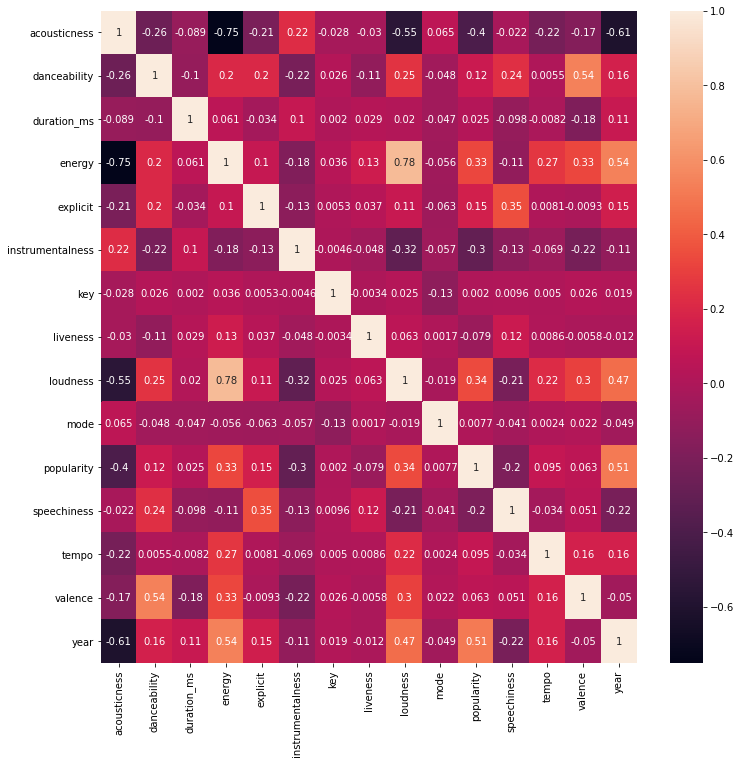

In [239]:
corrmat = X_data.corr(method="pearson")
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(corrmat, annot = True)
plt.show()

Some variables as expected are highly correlated like: 

- loudness and energy __(0.779267)__
- acousticness and energy __(-0.750852)__
- year and acousticness __(-0.607515)__ 

__Methods for eliminate highly correlated features__

__Brute force__: Determine correlation between a selected feature and every other. If the feature is highly correlated, drop it. __Problem__: This can lead to eliminate better features.

__Grouping__:

    1. Identify groups of correlated features.
    2. Select the feature with higher predictive power (train a ml model on each group and select the best feature, or keep the feature with the less number of missing values)
    3. Discard the rest

In [119]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [56]:
# Values for the feature selection
constant_feat_tolerance = 0.92
correlation_threshold = 0.75
correlation_method = "pearson"

correlation_forest_random_state = 1
correlation_forest_jobs = 4
correlation_forest_cv = 2 # 
correlation_metric = "roc_auc" # optimization metric

In [57]:
correlation_forest = RandomForestClassifier(
    random_state=correlation_forest_random_state,
    n_jobs=correlation_forest_jobs
)

In [58]:
correlation_classifier = MultiOutputClassifier(correlation_forest, n_jobs=-1)

In [59]:
# Group based

correlation_approach = SmartCorrelatedSelection(
    method=correlation_method,
    threshold=correlation_threshold,
    selection_method="model_performance",
    missing_values="raise",
    estimator=correlation_classifier,
    scoring=correlation_metric,
    cv=correlation_forest_cv
)

# Brute Force

# correlation_approach = DropCorrelatedFeatures(
#     threshold=correlation_threshold,
#     method=correlation_method,
#     missing_values="ignore"
# )

In [60]:
feat_sel_pipeline = Pipeline([
    ("quasi-constant", DropConstantFeatures(tol=constant_feat_tolerance)),
    ("duplicated", DropDuplicateFeatures()),
    ("correlation", correlation_approach)
])

In [61]:
feat_sel_pipeline.fit(X_train, y_train)

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [34]:
feat_sel_pipeline[0].features_to_drop_

['explicit']

In [35]:
feat_sel_pipeline[1].features_to_drop_

set()

In [36]:
feat_sel_pipeline[2].features_to_drop_

[]

In [37]:
feat_sel_pipeline[2].correlated_feature_sets_

[]

In [38]:
dir(feat_sel_pipeline[2])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'correlated_feature_sets_',
 'cv',
 'estimator',
 'features_to_drop_',
 'fit',
 'fit_transform',
 'get_params',
 'input_shape_',
 'method',
 'missing_values',
 'scoring',
 'selection_method',
 'set_params',
 'threshold',
 'transform',
 'variables']

## Feature scaling (not needed for tree based methods)



- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)


## Train a multilabel classifier (test)

The current danuniqueset is highly imbalanced given that most of the samples correspond to unique classes (over 48% percent). Furthermore, there are a high dimensionality having 32540 classes.
Widely speaking there are 2 Multilabel classification methods:

- __Algorithm adaptation methods__

Modify the algorithm to build decision trees or the entropy definition to consider various classes.

- __Problem transformation methods:__ Convert the problem into a combination of binary classification or multiclass classification problems.
    - __Simple:__ Ignore classes by frequency in each sample (keep the class with higher frequency)    
    - __Binary Relevance__: Divide the dataset into different datasets with each one containing the instances of one specific label. Train n_classes classifiers with these datasets and merge the prediction to get the final result. __Problem__: This will produce datasets with 1 sample, insufucient to train any supervised learning model.

    - __Label Powerset__: Treats every combination in the dataset as a single class (resulting with more classes in this case). __Problem__: This is more prior to imbalance problems, the number of classes in this approach increase with respect to multilabel classes (artist)

    - __Pruned set__: Solves imbalanced class distribution by pruning instances that have frequency less that specific threshold.


__Experiments__

- Train as it is (don't remove any label)
- Train using pruned set
- Train using pruned set plus some imbalanced handling tecniques (undersampling high frequency classes and oversampling low frequency)

__With all use:__

- Random Forest
- XGBoost
- Feed Forward Neural Network (MLP)

## Splitting the dataset

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_data, df_target, test_size=0.2, random_state=1)

In [78]:
X_train.shape, X_test.shape

((139511, 15), (34878, 15))

## Scaling variables

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()